# Day 2, session 2: Extracting signal tracks from contact matrices

In this session we will extract biologically relevant signal tracks from contact matrices.
We will be working with published data from [Bonev et al. 2017](https://doi.org/10.1016/j.cell.2017.09.043).
We have 2 cool files at 5kb resolution:

* mouse Embryonic stem cells (mESC)
* Neuroprogenitor cells (NPC)

Here, we will be comparing these two stages of differentiation using different features extracted from contact maps.

## Multiresolution files

The cool files provided are at 5kb resolution. There is a trade-off when choosing a resolution for Hi-C contact maps. The higher resolution, the more details can be seen, however this also reduces the contrast, especially at longer ranges. This is visible by eye: At high resolutions, contacts quickly drop to near-zero values when going away from the diagonal. 

Depending on the coverage and signal we are interested in, we might need to use different resolutions. For example, short range signals like TADs or chromatin loops are analysed easily at high resolutions (e.g. 5-10kb), whereas compartments often require using lower resolutions (e.g. 50-100kb).

Fortunately, the cooler API offers a command to quickly generate cool files at multiple-resolutions. These files are called "mcool" files.

In [4]:
%%bash
cooler zoomify -p12 \
               -r 10000,50000,100000 \
               --balance \
               data/4DNFI9FPCAC7_G0G1_mESC_sub.cool \
               -o data/4DNFI9FPCAC7_G0G1_mESC_sub.mcool

INFO:cooler.cli.zoomify:Recursively aggregating "data/4DNFI9FPCAC7_G0G1_mESC_sub.cool"
INFO:cooler.cli.zoomify:Writing to "data/4DNFI9FPCAC7_G0G1_mESC_sub.mcool"
INFO:cooler.reduce:Copying base matrices and producing 3 new zoom levels.
INFO:cooler.reduce:Bin size: 10000
INFO:cooler.reduce:Aggregating from 10000 to 50000.
  import pandas.util.testing as tm

INFO:cooler.create:Creating cooler at "data/4DNFI9FPCAC7_G0G1_mESC_sub.mcool::/resolutions/50000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:60000440 66258460
INFO:cooler.reduce:50000271 60000440
INFO:cooler.reduce:20001248 30000049
INFO:cooler.reduce:10001261 20001248
INFO:cooler.reduce:40000037 50000271
INFO:cooler.reduce:30000049 40000037
INFO:cooler.reduce:0 10001261
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done
INFO:cooler.reduce:Aggregating from 50000 to 100000.
INFO:cooler.create:Creating cooler at "data/4DN

The resulting mcool file will actually contain multiple cool files withing its tree hierarchy. you can inspect it using `cooler tree output.mcool`. You should see a root note named `/resolutions` with children whose name is the resolution (e.g. `10000`). This path within the tree is named the URI any cool within a mcool can be accessed using its URI. The file path and URI are separated using `::/`. For example, to show a region of the matrix at 50kb resolution:

```bash
cooler show output.mcool::/resolutions/50000 'chr1:3000000-6000000'
```

Similarly, to access it from the python API:

In [5]:
import cooler
clr = cooler.Cooler('data/4DNFI9FPCAC7_G0G1_mESC_sub.mcool::/resolutions/50000')

## Insulation score

Insulation scores is used by many methods to measure a "border score". Insulation measures the depletion of contacts across a position, which is typically the case at TAD borders.

To compute insulation, we slide a "diamond" along the diagonal, with the diamond corner touching the diagonal. Here is a basic implementation to understand the concept:

In [6]:
import numpy as np

def insulation(mat, win_size=10):
    score = np.nan * np.ones(mat.shape[0])
    for i in range(0, mat.shape[0]):
        lo = max(0, i + 1 - win_size)
        hi = min(i + win_size, mat.shape[0])
        score[i] = np.nanmean(mat[lo : i + 1, i:hi])
    score /= np.median(score)
    return score

<IPython.core.display.Javascript object>


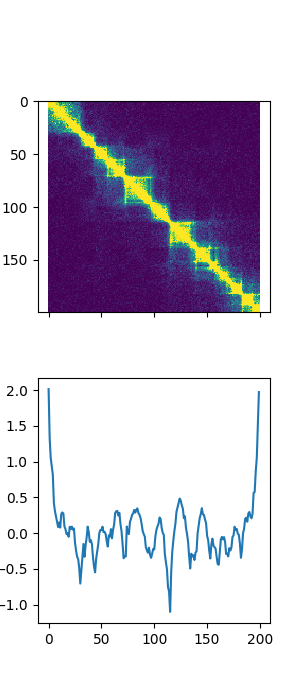

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.sparse as sp
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3, 7))
mat = clr.matrix(balance=True).fetch('chr1:8000000-18000000')
ax[0].imshow(mat, vmax=np.percentile(mat, 95))
ax[1].plot(np.log2(insulation(mat, win_size=10)))

> What is the consequence of changing the window size ?

> How would you choose a window size ?

> What are the main differences between insulation scores of NPC and mESC ?

In [19]:
# Region around sox2
region = "chr3:32,650,405-36,652,461"
# region = "chr8:10,395,295-14,400,126"
mesc = cooler.Cooler('data/4DNFI9FPCAC7_G0G1_mESC_sub.cool')
npc = cooler.Cooler('data/4DNFIEB68WXR_G0G1_NPC_sub.cool')

<IPython.core.display.Javascript object>


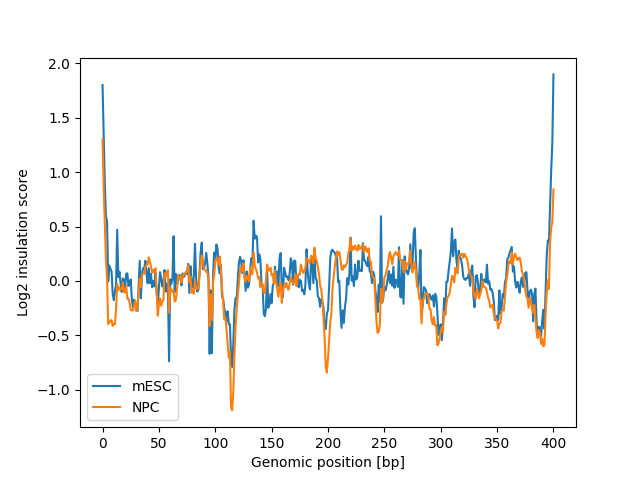

Text(0, 0.5, 'Log2 insulation score')

In [97]:
%matplotlib notebook
plt.plot(np.log2(insulation(mesc.matrix(balance=True).fetch(region))), label='mESC')
plt.plot(np.log2(insulation(npc.matrix(balance=True).fetch(region))), label='NPC')
plt.legend()
plt.xlabel('Genomic position [bp]')
plt.ylabel('Log2 insulation score')

Fortunately, this is already implemented in some packages such as cooltools. Using these tools is usually more convenient and safe (the code is tested) than rewriting custom scripts everytime:

In [ ]:
%%bash
cooltools diamond-insulation data/4DNFI9FPCAC7_G0G1_mESC_sub.cool 100000 > data/mESC_insulation_10kb.tsv
cooltools diamond-insulation data/4DNFIEB68WXR_G0G1_NPC_sub.cool 100000 > data/NPC_insulation_10kb.tsv

In [101]:
import pandas as pd

def parse_ucsc(ucsc_string):
    """Given a string in format 'chr:start-end', returns (chrom, start, end)"""
    chrom, bp = region.split(':')
    start, end = bp.replace(",", "").split('-')
    return chrom, start, end

def subset_insulation(insul_df, ucsc_region):
    """
    Given a dataframe of insulation scores and an interval in UCSC format,
    only return rows of the dataframe within the interval
    """
    r_chrom, r_start, r_end = parse_ucsc(region)

    reg_insul = insul_df.loc[
        (insul_df.chrom == r_chrom) &
        (insul_df.start > int(r_start)) &
        (insul_df.end < int(r_end))
    ]
    return reg_insul

insul_mesc = pd.read_csv('data/mESC_insulation_10kb.tsv', sep='\t')
insul_npc = pd.read_csv('data/NPC_insulation_10kb.tsv', sep='\t')

insul_mesc = subset_insulation(insul_mesc, region)
insul_npc = subset_insulation(insul_npc, region)

<IPython.core.display.Javascript object>


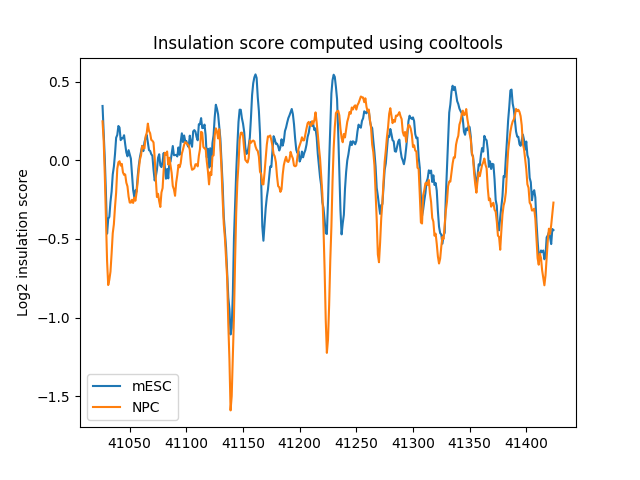

In [104]:
%matplotlib notebook
plt.plot(insul_mesc.log2_insulation_score_100000, label='mESC')
plt.plot(insul_npc.log2_insulation_score_100000, label='NPC')
plt.title("Insulation score computed using cooltools")
plt.ylabel("Log2 insulation score")
plt.legend()

> Why is the cooltools insulation score slightly different ? (look at the command line options)

It is often good and more intuitive to check visually the matrix ratios when doing some analyses.

<IPython.core.display.Javascript object>


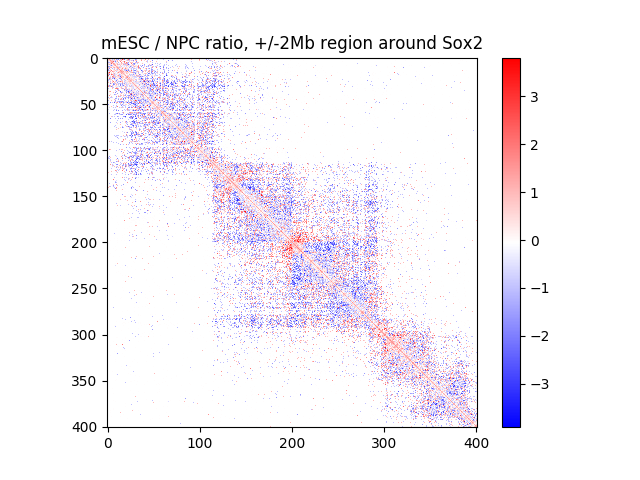

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
%matplotlib notebook
plt.title('mESC / NPC ratio, +/-2Mb region around Sox2')
plt.imshow(np.log2(mesc.matrix(balance=False).fetch(region)/npc.matrix(balance=False).fetch(region)), cmap='bwr')
plt.colorbar()

### Note: Cleaner ratios

Matrix ratios are usually noisy and hard to read, especially at longer ranges, where the signal to noise ratio is lower. Some methods like binless and serpentine attempt to adress this issue with adaptative binning . Below is a visualisation of the previous ratio compared to to the serpentine version.

The general idea of these techniques is to use larger pixels where contact values are smaller.
Official serpentine documentation: https://serpentine.readthedocs.io

<IPython.core.display.Javascript object>


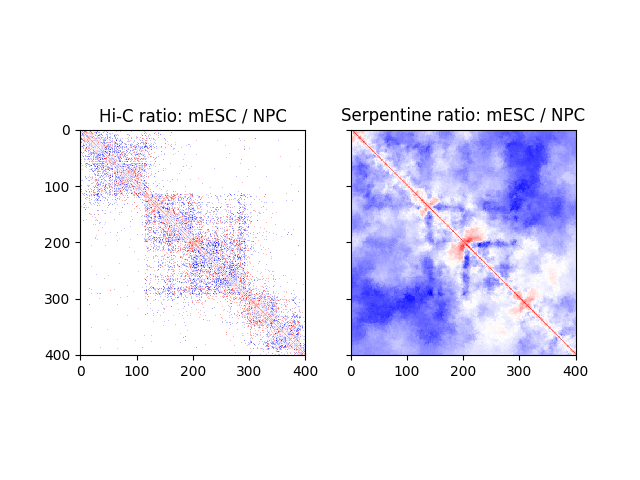

Text(0.5, 1.0, 'Serpentine ratio: mESC / NPC')

In [95]:
%matplotlib notebook
from serpentine import serpentin_binning

A = np.nan_to_num(mesc.matrix(balance=False).fetch(region), 0)
B = np.nan_to_num(npc.matrix(balance=False).fetch(region), 0)

sA, sB, sK = serpentin_binning(B,A,parallel=1,verbose=False,)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].imshow(np.log2(A/B), cmap='bwr')
ax[1].imshow(sK - np.median(sK), cmap='bwr')
ax[0].set_title('Hi-C ratio: mESC / NPC')
ax[1].set_title('Serpentine ratio: mESC / NPC')

## A/B Compartments

A/B compartments reflect types of chromatin (euchromatin / heterochromatin) which are isolated from each other. These compartments form characterstic "plaid" like patterns on Hi-C maps. The compartments coordinates can be extracted using PCA on detrended intrachromosomal matrices.

Since compartments are long range interactions, it is often better to use a lower resolution.

In [89]:
import cooler
from sklearn.decomposition import PCA
from chromosight.utils.preprocessing import detrend

# Get the whole matrix of chromosome 2 at 50kb
clr = cooler.Cooler('data/4DNFI9FPCAC7_G0G1_mESC_sub.mcool::/resolutions/50000')
mat = clr.matrix(balance=True).fetch('chr2')
mat = np.nan_to_num(mat, 0)

# Remove diagonal gradient (each pixel divided by the mean of its diagonal)
det = detrend(sp.csr_matrix(mat)).toarray()
pca = PCA(n_components=10)
pcs_df = pca.fit_transform(det)


/opt/anaconda3/lib/python3.7/site-packages/chromosight/utils/preprocessing.py:188: RuntimeWarning: Mean of empty slice
  dist[diag] = fun(detect_diag[detect_diag > 0])


<IPython.core.display.Javascript object>


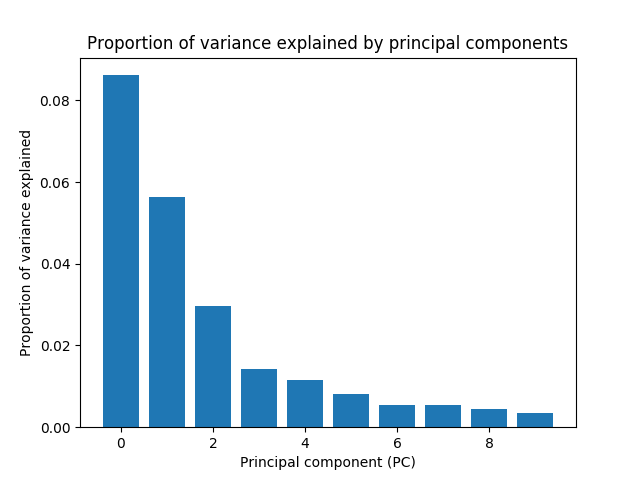

Text(0, 0.5, 'Proportion of variance explained')

In [90]:
%matplotlib notebook
plt.bar(range(pca.explained_variance_ratio_.shape[0]), height=pca.explained_variance_ratio_)
plt.title('Proportion of variance explained by principal components')
plt.xlabel("Principal component (PC)")
plt.ylabel("Proportion of variance explained")

<IPython.core.display.Javascript object>


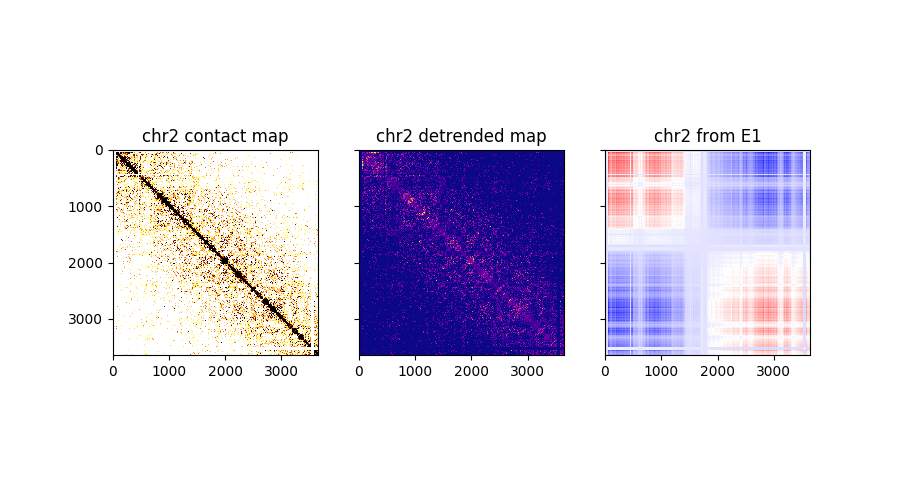

Text(0.5, 1.0, 'chr2 from E1')

In [107]:
%matplotlib notebook

PC = 0  # Change me

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 5))
ax[0].imshow(mat, cmap='afmhot_r', vmax=0.001)
ax[0].set_title("chr2 contact map")
ax[1].imshow(det, cmap='plasma', vmax=5)
ax[1].set_title("chr2 detrended map")
# We can reconstruct the map from a single PC by doing a dot product with its transpose (PC1 x PC1.T)
ax[2].imshow(pcs_df[None, :, PC].T @ pcs_df[None, :, PC], cmap='bwr')
ax[2].set_title(f"chr2 from E{PC+1}")

> E1 (first PC) does not reflect compartment signal, what does it show ?

> Try other PCs, do you see compartments ?

> What changes when using the non-detrended Hi-C matrix (diagonal gradient still present) ?


In certain situations (like above), the compartment signal is not in the first eigenvector (E1) due to other interfering signal:

* When chromosomal arms are highly insulated, E1 can contain the left/right arm information. Doing PCA on each arm independently (treating them as separate chromosomes) solves the issue.
* In noisy datasets such a cancerous cell lines with many structural variants, the compartment signal sometimes ends up in E2 or even E3. This is why sorting eigenvectors by their correlation with an external signal is important.

> Tip: To quickly download / search for genomes and annotations, check out [genomepy](https://github.com/vanheeringen-lab/genomepy)

Below is a more convenient implementation using cooltool's helper functions. It save the hassle of phasing and sorting eigenvectors:

In [109]:
from cooltools.eigdecomp import cooler_cis_eig
import bioframe

binsize = 50000
fasta_records = bioframe.load_fasta('data/mm10.fa')
bins = clr.bins()[:]
bins['GC'] = bioframe.tools.frac_gc(bins, fasta_records)

# Compute 3 first eigenvectors, phase them (flip sign) by GC content and 
# sort eigen values and eigen vectors by their pearson correlation coefficient
# with GC content
lam, eig = cooler_cis_eig(
        clr,
        bins,
        n_eigs=3,
        phasing_track_col='GC',
        sort_metric='pearsonr'
)


ModuleNotFoundError: No module named 'cooltools'

## Saddle plots

Saddle plots are a way to visually represent the intensity of the compartment signal.

The eigenvectors are digitized into quantiles (e.g. 10% quantiles), and the average interaction between each combination of quantiles is computed. These averages are then plotted as a 2D heatmap where rows and columns are sorted according to the quantiles.

More details and explanations on saddle plots on the official documentation: https://cooltools.readthedocs.io/en/latest/notebooks/04_saddle-plots.html

In [108]:
# Dump eigenvector to a bedgraph file
eig.to_csv('data/eig.tsv', sep='\t')

NameError: name 'eig' is not defined

In [ ]:
%%bash
# Compute expected contacts (used internally to detrend matrix)
cooltools compute-expected data/4DNFI9FPCAC7_G0G1_mESC_sub.mcool::/resolutions/50000 -o data/exp.tsv
# Compute saddle and generate plot
cooltools compute-saddle data/4DNFI9FPCAC7_G0G1_mESC_sub.mcool::/resolutions/50000 data/eig.tsv data/exp.tsv -o data/saddle_mesc